## Import libraries


In [ ]:
!pip3 install datasets
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, userdata
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from transformers import BertTokenizer, BertForMaskedLM, BertModel, BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from huggingface_hub import login
from datasets import Dataset

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data Load and Cleaning

In [ ]:
#Option1. Gdrive (Option when internet is slow)
drive.mount('/content/drive')
path = '/content/drive/MyDrive/capstone project/fake reviews dataset.csv'
dataset = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Option2. Когда в ручную загрузил
# dataset = pd.read_csv('fake reviews dataset.csv')

In [ ]:
dataset[dataset['label']=='OR'].head()

,category,rating,label,text_
55,Home_and_Kitchen_5,5.0,OR,"These are just perfect, exactly what I was loo..."
56,Home_and_Kitchen_5,5.0,OR,Such a great purchase can't beat it for the price
57,Home_and_Kitchen_5,5.0,OR,What can you say--- cheap and it works as inte...
58,Home_and_Kitchen_5,5.0,OR,"These are so nice, sturdy, like the color choi..."
59,Home_and_Kitchen_5,5.0,OR,It is nice bowl and have had a fast shipping!


In [ ]:
dataset[dataset['label']=='CG'].head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
dataset.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [ ]:
dataset.shape

(40432, 4)

In [ ]:
dataset.isna().sum()

,0
category,0
rating,0
label,0
text_,0


In [ ]:
dataset.duplicated().sum()

np.int64(12)

In [ ]:
dataset.drop_duplicates(inplace=True)

In [ ]:
dataset.dtypes

,0
category,object
rating,float64
label,object
text_,object


In [ ]:
dataset[dataset['text_'].apply(lambda x: len(x) < 30)]

,category,rating,label,text_
8074,Electronics_5,5.0,OR,It is working as I expected.
37914,Clothing_Shoes_and_Jewelry_5,4.0,CG,. .


In [ ]:
dataset['category'].unique()

array(['Home_and_Kitchen_5', 'Sports_and_Outdoors_5', 'Electronics_5',
       'Movies_and_TV_5', 'Tools_and_Home_Improvement_5',
       'Pet_Supplies_5', 'Kindle_Store_5', 'Books_5', 'Toys_and_Games_5',
       'Clothing_Shoes_and_Jewelry_5'], dtype=object)

In [ ]:
label_count = dataset['label'].value_counts()
label_count = label_count.reset_index()
label_count

,label,count
0,OR,20215
1,CG,20205


<Axes: xlabel='label', ylabel='count'>

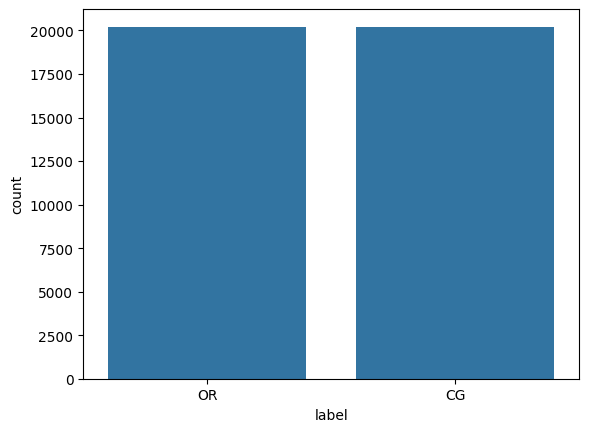

In [ ]:
sns.barplot(x='label', y='count', data=label_count)

In [ ]:
dataset['text_length'] = dataset['text_'].apply(lambda x: len(x))

In [ ]:
dataset.head()

,category,rating,label,text_,text_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",75
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",80
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,67
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",81
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,85


In [ ]:
dataset.groupby('label')['text_length'].max()

,text_length
label,
CG,1717
OR,2827


<Axes: xlabel='text_length', ylabel='label'>

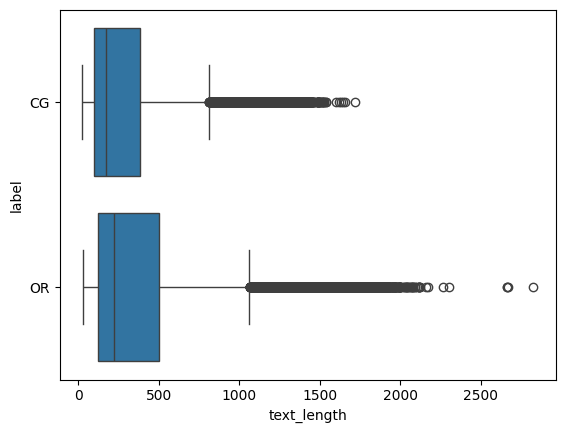

In [ ]:
sns.boxplot(data=dataset, x='text_length', y='label')
# Настоящие отзывы (OR) в среднем длиннее, чем фейковые (CG), и имеют больший разброс по длине. Это может быть полезным признаком для модели.

<Axes: xlabel='text_length', ylabel='Count'>

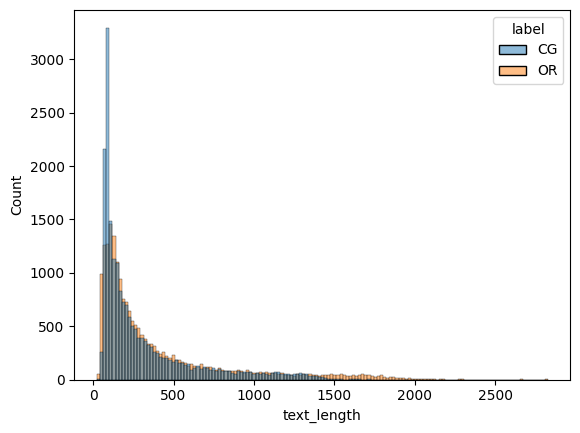

In [ ]:
sns.histplot(data=dataset, x='text_length', hue='label')
# 1)CG-отзывы плотнее сгруппированы в короткой зоне. OR — более разнообразны по длине.
# 2)Распределение длины текста показывает, что фейковые отзывы (CG) редко превышают 1500 символов,
# в то время как настоящие (OR) встречаются даже до 2500+ символов.

## Text preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()
stopwords_list = set(stopwords.words("english"))
url_pattern = re.compile(r'https?://\S+')



def preprocessing_text(text):
  text = text.lower()
  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text(separator=' ', strip=True)
  text = url_pattern.sub('', text)
  text = re.sub(r'[^\w\s]', '', text)
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stopwords_list]
  lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
  return lemmatized_words

dataset['clean_text'] = dataset['text_'].apply(preprocessing_text)

In [ ]:
pd.set_option('display.max_colwidth', 1000)
filtered = dataset[dataset['clean_text'].str.contains(r'https?://', na=False)]
dataset



,category,rating,label,text_,text_length,clean_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty",75,"[love, well, made, sturdy, comfortable, love, itvery, pretty]"
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I've had mine for a couple of years",80,"[love, great, upgrade, original, ive, mine, couple, year]"
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and feel of this pillow.,67,"[pillow, saved, back, love, look, feel, pillow]"
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it is a great product for the price! I",81,"[missing, information, use, great, product, price]"
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the set for two months now and have not been,85,"[nice, set, good, quality, set, two, month]"
...,...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,"I had read some reviews saying that this bra ran small and so I ordered TWO band AND cup sizes UP and it was still too small! Definitely along the lines of a sports bra squish effect. The sides do come up high. Glamorise is one the best brands for bras, so I'm very surprised with this one. The front close idea appealed to me, but look carefully, there are 7 (yes, seven) clasps to do up. What a pain. I think if I had ordered 3 sizes up it might be ok. I won't return it as I'm losing weight, so it might fit better down the road. Will update review at that time. If you want a bra that doesn't let you jiggle at all without it being a minimizer and/or without wires, this would be good.\n\nUPDATE: After very recent gallbladder surgery that left me with a highly tender incision site, I found I couldn't wear any of my regular bras. I had ordered this one hoping I might be able to tolerate it. Initially, because it was so tight, I couldn't tolerate this one either. As I slowly ...",1694,"[read, review, saying, bra, ran, small, ordered, two, band, cup, size, still, small, definitely, along, line, sport, bra, squish, effect, side, come, high, glamorise, one, best, brand, bra, im, surprised, one, front, close, idea, appealed, look, carefully, 7, yes, seven, clasp, pain, think, ordered, 3, size, might, ok, wont, return, im, losing, weight, might, fit, better, road, update, review, time, want, bra, doesnt, let, jiggle, without, minimizer, andor, without, wire, would, good, update, recent, gallbladder, surgery, left, highly, tender, incision, site, found, couldnt, wear, regular, bra, ordered, one, hoping, might, able, tolerate, initially, tight, couldnt, tolerate, one, either, slowly, healed, ...]"
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,"I wasn't sure exactly what it would be. It is a little large for my small size, but I think it is a nice fit. The fabric is a nice thin material, but it is a little thin in the legs. I wish it was thicker. The material is soft and comfortable. I will keep it. I ordered a half size up and it fits great. I wear a 9 1/2. I like that the strap is longer than the waistband, which is nice. I am 5'5"" and the size 6 fits great. I am a medium. The bra is too short. It is a little narrow for me, but I think it would be a nice addition to my wardrobe. I will be buying another one in different colors. I have a small tummy and I ordered a medium. I wear a 9 1/2 in pants. I would recommend this bra. I am 5'8"" and the length was perfect. I love the color and it is very comfortable.\nI would recommend this to anyone.I was very happy with this shirt! It's very pretty and the fabric is soft and nice! The fit is perfect! I bought a small and it fit perfectly! It is well made and ...",1304,"[wasnt, sure, exactly, would, little, large, small, size, think, nice, fit, fabric, nice, thin, material, little, thin, leg, wish, thicker, material, soft, comfortable, keep, ordered, half, size, fit, great, wear, 9, 12, like, strap, longer, waistband, nice, 55, size, 6, fit, great, medium, bra, short, little

## Feature Engineering

In [ ]:
def has_mashed_words(text):
  return bool(re.search(r'\w[!.?]\w', text))
dataset['has_mashed'] = dataset['text_'].apply(has_mashed_words)
print(dataset[dataset['label']=='CG']['has_mashed'].value_counts())
print(dataset[dataset['label']=='OR']['has_mashed'].value_counts())


has_mashed
False    14210
True      5995
Name: count, dtype: int64
has_mashed
False    19328
True       887
Name: count, dtype: int64


In [ ]:
def has_all_caps(text):
    return bool(re.search(r'\b[A-Z]{3,}\b', text))
dataset['all_caps'] = dataset['text_'].apply(has_all_caps)
print(dataset[dataset['label']=='CG']['all_caps'].value_counts())
print(dataset[dataset['label']=='OR']['all_caps'].value_counts())


all_caps
False    18713
True      1492
Name: count, dtype: int64
all_caps
False    16789
True      3426
Name: count, dtype: int64


In [ ]:
def has_repeat_phrases(text):
    return bool(re.search(r'(\b\w+\b)[^\w]+\1', text.lower()))
dataset['repeated_words'] = dataset['text_'].apply(has_repeat_phrases)
print(dataset[dataset['label']=='CG']['repeated_words'].value_counts())
print(dataset[dataset['label']=='OR']['repeated_words'].value_counts())

repeated_words
False    17786
True      2419
Name: count, dtype: int64
repeated_words
False    16782
True      3433
Name: count, dtype: int64


In [ ]:
cg_tokens = dataset[dataset['label'] == 'CG']['clean_text'].explode()
cg_fdist = FreqDist(cg_tokens)

or_tokens = dataset[dataset['label'] == 'OR']['clean_text'].explode()
or_fdist = FreqDist(or_tokens)

cg_words = set([word for word, freq in cg_fdist.most_common(20)])
or_words = set([word for word, freq in or_fdist.most_common(20)])

only_cg = cg_words - or_words
only_or = or_words - cg_words
common_words = cg_words & or_words

In [ ]:
print('CG only most coomon words:', only_cg)
print('OR only most common words:', only_or)
print('Common words for both:', common_words)


CG only most coomon words: {'small', 'im', 'character', 'bought', 'movie', 'recommend', 'nice'}
OR only most common words: {'work', 'make', 'much', 'use', 'dont', 'really', 'time'}
Common words for both: {'well', 'read', 'one', 'get', 'like', 'great', 'book', 'also', 'little', 'good', 'would', 'love', 'story'}


## EDA

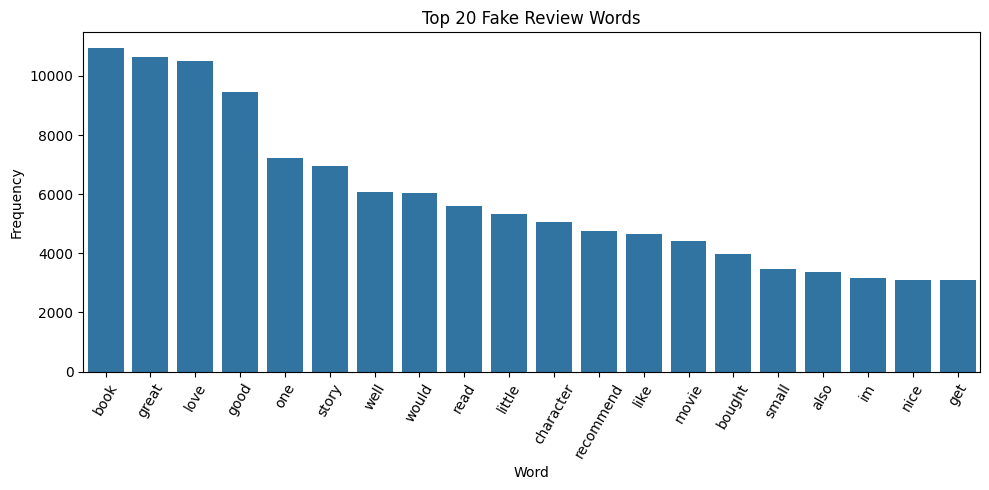

In [ ]:
cg_w_freq = cg_fdist.most_common(20)
cg_w_freq = pd.DataFrame(cg_w_freq, columns=['word', 'frequency'])
plt.figure(figsize=(10, 5))
sns.barplot(data=cg_w_freq, x='word', y='frequency')
plt.xticks(rotation=60, fontsize=10)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Fake Review Words')
plt.tight_layout()
plt.show()

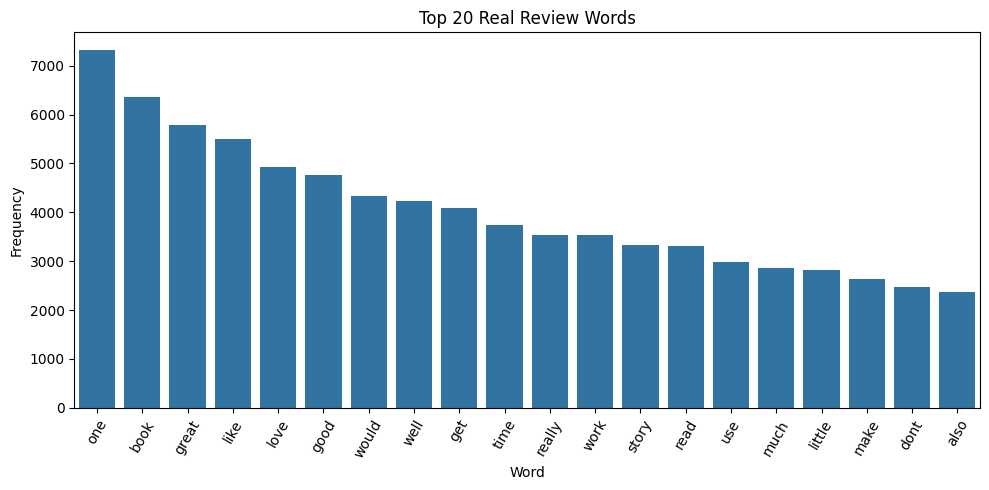

In [ ]:
or_w_freq = or_fdist.most_common(20)
or_w_freq = pd.DataFrame(or_w_freq, columns=['word', 'frequency'])
plt.figure(figsize=(10, 5))
sns.barplot(data=or_w_freq, x='word', y='frequency')
plt.xticks(rotation=60, fontsize=10)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Real Review Words')
plt.tight_layout()
plt.show()

In [ ]:
dataset.head()

,category,rating,label,text_,text_length,clean_text,has_mashed,all_caps,repeated_words
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty",75,"[love, well, made, sturdy, comfortable, love, itvery, pretty]",True,False,False
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I've had mine for a couple of years",80,"[love, great, upgrade, original, ive, mine, couple, year]",False,False,False
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and feel of this pillow.,67,"[pillow, saved, back, love, look, feel, pillow]",False,False,False
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it is a great product for the price! I",81,"[missing, information, use, great, product, price]",False,False,False
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the set for two months now and have not been,85,"[nice, set, good, quality, set, two, month]",False,False,False


In [ ]:
dataset['clean_text_str'] = dataset['clean_text'].apply(lambda tokens: " ".join(tokens))
cg_texts = dataset[dataset['label']=='CG']['clean_text_str']
or_texts = dataset[dataset['label']=='OR']['clean_text_str']
tfidf_cg_vect = TfidfVectorizer()
tfidf_or_vect = TfidfVectorizer()
tfidf_cg = tfidf_cg_vect.fit_transform(cg_texts)
tfidf_or = tfidf_or_vect.fit_transform(or_texts)

In [ ]:
feature_names = tfidf_cg_vect.get_feature_names_out()
avg_tfidf_cg = np.asarray(tfidf_cg.mean(axis=0)).flatten()
top_n = 20
tfidf_cg_indices = avg_tfidf_cg.argsort()[::-1][:top_n]
top_cg_words = [(feature_names[i], avg_tfidf_cg[i]) for i in tfidf_cg_indices]
for word, score in top_cg_words:
  print(f'{word}: {score:.4f} ')

book: 0.0425 
love: 0.0396 
great: 0.0366 
good: 0.0329 
one: 0.0289 
story: 0.0278 
read: 0.0259 
well: 0.0251 
little: 0.0226 
movie: 0.0225 
character: 0.0225 
bought: 0.0201 
would: 0.0201 
like: 0.0181 
small: 0.0180 
nice: 0.0177 
dog: 0.0172 
quality: 0.0168 
fit: 0.0167 
work: 0.0163 


In [ ]:
feature_names = tfidf_or_vect.get_feature_names_out()
avg_tfidf_or = np.asarray(tfidf_or.mean(axis=0)).flatten()
tfidf_or_indices = avg_tfidf_or.argsort()[::-1][:top_n]
top_or_words = [(feature_names[i], avg_tfidf_or[i]) for i in tfidf_or_indices]
for word, score in top_or_words:
  print(f'{word}: {score:.4f}')

great: 0.0248
book: 0.0238
love: 0.0224
one: 0.0212
good: 0.0195
like: 0.0180
well: 0.0162
work: 0.0156
would: 0.0147
read: 0.0142
story: 0.0141
really: 0.0138
get: 0.0137
time: 0.0131
use: 0.0120
fit: 0.0120
little: 0.0117
product: 0.0109
much: 0.0108
nice: 0.0108


##  TF-IDF + ML models (Logistic Regression and Random Forest)

In [ ]:
tfidf_vect = TfidfVectorizer( max_features=20000)
# ngram_range=(1,2), max_df=0.9, min_df=5,
X_text = tfidf_vect.fit_transform(dataset['clean_text_str'])

X_meta = dataset[['text_length', 'has_mashed', 'all_caps', 'repeated_words']].astype(float)

X = hstack([X_text, X_meta])
y = dataset['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
    )


In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
target_names = ['CG', 'OR']
print(cnf_matrix)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

[[3229  812]
 [ 549 3494]]
              precision    recall  f1-score   support

          CG       0.85      0.80      0.83      4041
          OR       0.81      0.86      0.84      4043

    accuracy                           0.83      8084
   macro avg       0.83      0.83      0.83      8084
weighted avg       0.83      0.83      0.83      8084



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
tfidf_features = tfidf_vect.get_feature_names_out()
print(tfidf_features[-20:])

['zippered' 'zipping' 'zipup' 'ziti' 'zoe' 'zoey' 'zojirushi' 'zombie'
 'zombieland' 'zombiestrike' 'zone' 'zoo' 'zoom' 'zooming' 'zt' 'zucchini'
 'zumba' 'zurg' 'zwave' 'zymox']


In [ ]:
meta_features = ['text_length', 'has_mashed', 'all_caps', 'repeated_words']
all_feature_names = np.concatenate([tfidf_features, meta_features])

In [ ]:
weights = logreg.coef_[0]
top_n = 20
top_cg = sorted(zip(weights, all_feature_names), reverse=True)[:top_n]
top_or = sorted(zip(weights, all_feature_names))[:top_n]

In [ ]:
print('Признаки указывающие на CG:')
for weight, feature in top_cg:
  print(f'{feature:25} +{weight:.4f}')

print('\nПризнаки указывающие на OR:')
for weight, feature in top_or:
  print(f'{feature:25} +{weight:.4f}')

Признаки указывающие на CG:
even                      +4.0680
much                      +3.6422
though                    +2.6377
could                     +2.4481
end                       +2.3139
every                     +2.1773
without                   +2.0980
another                   +1.9518
really                    +1.9314
far                       +1.8751
however                   +1.8456
better                    +1.7717
got                       +1.7514
buy                       +1.7257
always                    +1.6493
back                      +1.6141
others                    +1.6030
something                 +1.5952
never                     +1.5897
everything                +1.5824

Признаки указывающие на OR:
problem                   +-7.0954
small                     +-6.3820
little                    +-5.9282
reason                    +-5.8798
also                      +-5.6597
couple                    +-5.2304
plastic                   +-5.2116
bit               

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, rf_pred, target_names=target_names))

              precision    recall  f1-score   support

          CG       0.85      0.89      0.87      4041
          OR       0.89      0.85      0.87      4043

    accuracy                           0.87      8084
   macro avg       0.87      0.87      0.87      8084
weighted avg       0.87      0.87      0.87      8084



In [ ]:
rf_feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_feature_importances
})
top_n = 20
top_rf_importances = importance_df.sort_values(by='importance', ascending=False).head(top_n)
print(top_rf_importances)

           feature  importance
20001   has_mashed    0.031469
20000  text_length    0.026906
10497         love    0.011223
7904          good    0.008894
8057         great    0.008075
10374       little    0.007917
3459     character    0.007572
1070          also    0.007533
12405          one    0.007196
16258        small    0.007182
13880      problem    0.006910
6297          even    0.006642
14344       reason    0.006350
2514          book    0.006058
2318           bit    0.005993
11669         much    0.005788
14406    recommend    0.005745
17033        story    0.005727
2591        bought    0.005656
11628        movie    0.005294


In [ ]:
import numpy as np
from scipy.sparse import hstack

def predict_sample(text, model, tfidf_vectorizer):
    # Предобработка
    tokens = preprocessing_text(text)
    cleaned_str = ' '.join(tokens)

    # TF-IDF вектор
    X_text_sample = tfidf_vectorizer.transform([cleaned_str])

    # Ручные фичи (как в X_meta)
    def has_mashed_words(text):
        return bool(re.search(r'\w[!.?]\w', text))

    def has_all_caps(text):
        return bool(re.search(r'\b[A-Z]{3,}\b', text))

    def has_repeat_phrases(text):
        return bool(re.search(r'(\b\w+\b)[^\w]+\1', text.lower()))

    sample_meta = np.array([[len(text),
                             has_mashed_words(text),
                             has_all_caps(text),
                             has_repeat_phrases(text)]], dtype=float)

    # Объединение признаков
    X_sample = hstack([X_text_sample, sample_meta])

    # Предсказание
    pred = model.predict(X_sample)[0]
    proba = model.predict_proba(X_sample)[0]

    return pred, proba


## BERT Embeddings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def bert_tokenize(dataset):
  return tokenizer(list(dataset['clean_text_str']),
    padding='max_length',
    max_length=128,
    truncation=True,
    return_tensors='pt')

batch_size=32
X_bert_list = []
for i in range(0, len(dataset), batch_size):
  batch_texts=dataset['clean_text_str'].iloc[i:i+batch_size]
  encoded_batch = tokenizer(
    list(batch_texts),
    padding='max_length',
    max_length=128,
    truncation=True,
    return_tensors='pt')

  encoded_batch = {k: v.to(device) for k, v in encoded_batch.items()}

  with torch.no_grad():
    outputs=bert_model(**encoded_batch)
    last_hidden_state = outputs.last_hidden_state
    batch_embeddings = last_hidden_state.mean(dim=1)
    X_bert_list.append(batch_embeddings.cpu())


X_bert = torch.cat(X_bert_list, dim=0).numpy()


y_bert = dataset['label'].values

In [ ]:
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
    X_bert, y_bert,
    test_size=0.2,
    stratify=y_bert,
    random_state=42
)


In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_bert_train, y_bert_train)
y_bert_pred = logreg.predict(X_bert_test)
cnf_matrix = metrics.confusion_matrix(y_bert_test, y_bert_pred)
target_names = ['CG', 'OR']
print(cnf_matrix)
print(metrics.classification_report(y_bert_test, y_bert_pred, target_names=target_names))

[[3384  657]
 [ 657 3386]]
              precision    recall  f1-score   support

          CG       0.84      0.84      0.84      4041
          OR       0.84      0.84      0.84      4043

    accuracy                           0.84      8084
   macro avg       0.84      0.84      0.84      8084
weighted avg       0.84      0.84      0.84      8084



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Fine-tune BERT

In [ ]:
bert_finetuning = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_finetuning = bert_finetuning.to(device)
bert_finetuning.config.label2id = {'CG': 1, 'OR': 0}
bert_finetuning.config.id2label = {1: 'CG', 0: 'OR'}

label_mapping = {'CG': 1, 'OR': 0}
dataset['label'] = dataset['label'].map(label_mapping)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
hf_ds = Dataset.from_pandas(dataset[['clean_text_str', 'label']])
def tokenize_fn(examples):
  return tokenizer(
      examples['clean_text_str'],
      padding='max_length',
      truncation=True,
      max_length=128
      )
hf_ds = hf_ds.map(tokenize_fn, batched=True)

hf_ds = hf_ds.train_test_split(test_size=0.2, seed=42)
train_ds = hf_ds['train']
test_ds = hf_ds['test']



Map:   0%|          | 0/40420 [00:00<?, ? examples/s]

In [ ]:
train_ds

Dataset({
    features: ['clean_text_str', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32336
})

In [ ]:
train_ds.set_format(
    type = 'torch',
    columns = ['input_ids', 'attention_mask', 'label']
)

test_ds.set_format(
    type = 'torch',
    columns = ['input_ids', 'attention_mask', 'label']
)

In [ ]:
def compute_metrics(pred):
  logits, labels = pred
  preds = np.argmax(logits, axis=-1)
  p, r, f1, _ = metrics.precision_recall_fscore_support(labels, preds, average='binary')
  acc = metrics.accuracy_score(labels, preds)
  return {'acc': acc, 'prec': p, 'recall': r, 'f1': f1}

training_args = TrainingArguments(
    output_dir = './bert-finetune',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    eval_strategy = 'epoch',
    learning_rate = 2e-5,
    logging_steps = 100
)

trainer = Trainer(
    model = bert_finetuning,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = test_ds,
    processing_class = tokenizer,
    compute_metrics = compute_metrics
)

In [ ]:
# os.environ["WANDB_DISABLED"] = "true"
trainer.train()

Epoch,Training Loss,Validation Loss,Acc,Prec,Recall,F1
1,0.190700,0.158193,0.938026,0.925457,0.951177,0.938141
2,0.080400,0.334752,0.927511,0.890289,0.973210,0.929904
3,0.031800,0.379022,0.932830,0.901746,0.969705,0.934491


TrainOutput(global_step=6063, training_loss=0.1062899781358767, metrics={'train_runtime': 2551.5769, 'train_samples_per_second': 38.019, 'train_steps_per_second': 2.376, 'total_flos': 6476741738741760.0, 'train_loss': 0.1062899781358767, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.37902164459228516,
 'eval_acc': 0.9328302820385947,
 'eval_prec': 0.9017462165308499,
 'eval_recall': 0.9697045568352529,
 'eval_f1': 0.934491494752081,
 'eval_runtime': 55.5309,
 'eval_samples_per_second': 145.577,
 'eval_steps_per_second': 9.112,
 'epoch': 3.0}

## Model Evaluation and Save

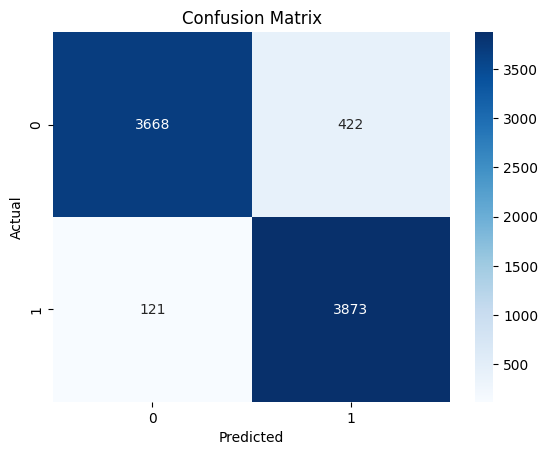

In [ ]:
preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

cm = metrics.confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
bert_finetuning.save_pretrained('./final-model')
tokenizer.save_pretrained('./final-model')

('./final-model/tokenizer_config.json',
 './final-model/special_tokens_map.json',
 './final-model/vocab.txt',
 './final-model/added_tokens.json',
 './final-model/tokenizer.json')

In [ ]:
path = '/content/drive/MyDrive/capstone project/finetuned-final-model'
bert_finetuning.save_pretrained(path)
tokenizer.save_pretrained(path)

('/content/drive/MyDrive/capstone project/finetuned-final-model/tokenizer_config.json',
 '/content/drive/MyDrive/capstone project/finetuned-final-model/special_tokens_map.json',
 '/content/drive/MyDrive/capstone project/finetuned-final-model/vocab.txt',
 '/content/drive/MyDrive/capstone project/finetuned-final-model/added_tokens.json',
 '/content/drive/MyDrive/capstone project/finetuned-final-model/tokenizer.json')

In [ ]:
!zip -r final-model.zip ./final-model
from google.colab import files
files.download('final-model.zip')

	zip warning: name not matched: ./final-model

zip error: Nothing to do! (try: zip -r final-model.zip . -i ./final-model)


FileNotFoundError: Cannot find file: final-model.zip